In [56]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader, random_split, Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split


from dataloader import CustomImageDataset
from my_models import SimpleCNN
import random

In [57]:
# Parameters
attention = 0 # Toggle to 1 to change aggregation function from max to attention
dropout = 0.5 # Change the probability % of dropping out nodes
min_number_images = 20 # Minimum number of cell images allowed for a sample to be considered
bag_size = 20 # Amount of images (randomply samples) per bag used in each epoch
class_weight = 1 # Toggle to 1 to apply positive weight as a means to tackle imbalanced data


In [58]:
# Define all the transforms

# Transform for loading dataset
transform_loading = transforms.Compose([
    transforms.Resize((64, 64)),  # resize to 64x64
    # transforms.Grayscale(),
    transforms.ToTensor()
])

In [59]:
# Create the dataset and dataloader

class_to_idx = {'sma': 1, 'non-sma': 0} # Dictionaty to assign 1 to 'sma' and 0 to 'non-sma' samples

# Get current directory
current_directory = os.getcwd()

# Relative directory of images
other_string = "Red_Cell_Morphology_binary_cells"

# Combine directpries
new_path = os.path.join(current_directory, other_string)

# Create dataset
dataset = CustomImageDataset(root_dir=new_path, class_to_idx=class_to_idx, min_number_images=min_number_images, transform=transform_loading)
        

# Define the train, validation, and test ratios (e.g., 70%, 15%, 15%)
train_ratio = 0.7
val_ratio = 0.3
test_ratio = 0.0

# Calculate the number of samples for each split
num_samples = len(dataset)
train_samples = int(train_ratio * num_samples)
val_samples = int(val_ratio * num_samples)
test_samples = num_samples - train_samples - val_samples

# Use random_split to split the dataset
train_set, val_set, test_set = random_split(dataset, [train_samples, val_samples, test_samples])

# Create data loaders for each split
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)  # No need to shuffle validation set
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)  # No need to shuffle test set


In [60]:
# Get counts
counts = dataset.get_class_counts()
print(counts)

{'sma': 30, 'non-sma': 82}


Code that checks if the sample/bag has less than 20 RBC images and deleted the sample if they are less. This is not correct. TBD

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('This will run on', device)

This will run on cuda


In [62]:
# Dealing with imbalanced dataset


# Option 1: Class weighting
pos_weight=1 # Default class weight

if class_weight==1:
    sma_num = counts['sma']
    non_sma_num = counts['non-sma']
    pos_weight = torch.tensor([non_sma_num/sma_num])
    print('The weight applied to the positive class is: ', pos_weight)

# Option 2: Oversampling

The weight applied to the positive class is:  tensor([2.7333])


In [63]:
# Initialize the network and optimizer
net = SimpleCNN(dropout=dropout, attention=attention) 

net.to(device) # Move model to GPU ---> I have this twice

loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
loss_fn.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.00001)

# Initialize lists to store accuracy values
train_accuracy_list = []
val_accuracy_list = []
test_accuracy = 0.0       
loss_tracker=[]
val_f1_tracker = []
val_roc_auc_tracker = []

# Training loop
net.train()

for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader),desc=f'Epoch {epoch+1}/{1}', unit='batch',) as pbar:
        for i, data in enumerate(train_loader, 0):

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels,_ = data
            
            # Move each tensor in the list, all labels, and the model to the GPU
            inputs = [tensor.to(device) for tensor in inputs]
            labels = labels.to(device)
            net = net.to(device)
            
            # Make a prediciton by passing inputs sample through network
            target = net(inputs, mode='train')
    
            # Calculate the loss
            loss = loss_fn(target[0],labels.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_tracker.append(loss)

            # Update accuracy
            predicted = target.data.round().int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # print statistics
            running_loss += loss.item()
            
            # Print loss in every minibatch
            pbar.update(1)

    # Calculate training accuracy
    train_accuracy = 100 * correct / total
    print("Training accuracy   : ", train_accuracy)
                                                                                    
    train_accuracy_list.append(train_accuracy)

    # Validation metrics - store and print validation metrics at the end of each epoch
    net.eval()  # Switch to evaluation mode                                                                                                                                                                     
    val_correct = 0
    val_total = 0
    val_act_labels=[]
    val_pred_labels=[]

    with torch.no_grad():
        for data in val_loader:
            inputs, labels,_ = data
            inputs = [tensor.to(device) for tensor in inputs]
            
            # Make prediction for validation data
            target = net(inputs, mode='eval')
            target = target.to(device)

            # Load the actual labels
            labels = labels.to(device)
            
            # Calculate validation accuracy
            predicted = target.data.round().int()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate F1 score for validation set
            val_predicted_probs = target.cpu().numpy()
            val_predicted_labels = np.round(val_predicted_probs,0)
            
            # print(val_predicted_labels.item().type())

            val_act_labels.append(labels.cpu().numpy().item())
            val_pred_labels.append(int(val_predicted_labels.item()))
    
    # Calculate accuracy for validation set
    val_accuracy = 100 * val_correct / val_total

    # Calculate F1 score for validation set
    val_f1 = f1_score(val_act_labels, val_pred_labels) 

    # Calculate AUC curve for validation set
    fpr, tpr, _ = roc_curve(val_act_labels, val_pred_labels)
    val_roc_auc = auc(fpr, tpr)

    # Store metrics in lists to plot afterwards
    val_accuracy_list.append(val_accuracy)
    val_f1_tracker.append(val_f1*100)
    val_roc_auc_tracker.append(val_roc_auc*100)

    # Print validation metrics
    print("Validation accuracy : ", val_accuracy)
    print("Validation F1 score : ", val_f1*100)
    print("Validation AUC      : ", val_roc_auc*100)


# Testing metrics - calculate test accuracy at the end of training --> THIS MIGHT BE WRONG
net.eval()  # Switch to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels,_ = data
        inputs = [tensor.to(device) for tensor in inputs]

        target = net(inputs,mode='eval')
        target = target.to(device)
        labels = labels.to(device)

        # Calculate test accuracy
        predicted = target.data.round().int()
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

classtest_accuracy = 100 * test_correct / test_total

# Calculate F1 score for test set
test_predicted_probs = torch.sigmoid(target).cpu().numpy()
test_predicted_labels = np.round(test_predicted_probs)
test_f1 = f1_score(labels.cpu().numpy(), test_predicted_labels)

# Calculate ROC curve for test set
fpr, tpr, _ = roc_curve(labels.cpu().numpy(), test_predicted_probs)
test_roc_auc = auc(fpr, tpr)

print(f'Test Accuracy: {test_accuracy:.2f}%')
print("Test F1 score : ", test_f1*100)
print("Test AUC      : ", test_roc_auc*100)

print('Finished Training')


/home/fabspace/anaconda3/envs/EzerM/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/fabspace/anaconda3/envs/EzerM/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/1: 100%|██████████| 78/78 [00:15<00:00,  5.07batch/s]


Training accuracy   :  66.66666666666667
Validation accuracy :  69.6969696969697
Validation F1 score :  0.0
Validation AUC      :  50.0


Epoch 2/1: 100%|██████████| 78/78 [00:14<00:00,  5.30batch/s]


Training accuracy   :  75.64102564102564
Validation accuracy :  69.6969696969697
Validation F1 score :  0.0
Validation AUC      :  50.0


Epoch 3/1: 100%|██████████| 78/78 [00:14<00:00,  5.37batch/s]


Training accuracy   :  75.64102564102564
Validation accuracy :  69.6969696969697
Validation F1 score :  0.0
Validation AUC      :  50.0


Epoch 4/1: 100%|██████████| 78/78 [00:14<00:00,  5.37batch/s]


Training accuracy   :  75.64102564102564
Validation accuracy :  69.6969696969697
Validation F1 score :  0.0
Validation AUC      :  50.0


Epoch 5/1: 100%|██████████| 78/78 [00:14<00:00,  5.32batch/s]


Training accuracy   :  76.92307692307692
Validation accuracy :  69.6969696969697
Validation F1 score :  0.0
Validation AUC      :  50.0


Epoch 6/1: 100%|██████████| 78/78 [00:14<00:00,  5.31batch/s]


Training accuracy   :  75.64102564102564
Validation accuracy :  69.6969696969697
Validation F1 score :  0.0
Validation AUC      :  50.0


Epoch 7/1: 100%|██████████| 78/78 [00:14<00:00,  5.33batch/s]


Training accuracy   :  75.64102564102564
Validation accuracy :  69.6969696969697
Validation F1 score :  0.0
Validation AUC      :  50.0


Epoch 8/1: 100%|██████████| 78/78 [00:14<00:00,  5.37batch/s]


Training accuracy   :  78.2051282051282
Validation accuracy :  57.57575757575758
Validation F1 score :  41.666666666666664
Validation AUC      :  55.434782608695656


Epoch 9/1: 100%|██████████| 78/78 [00:14<00:00,  5.40batch/s]


Training accuracy   :  78.2051282051282
Validation accuracy :  51.515151515151516
Validation F1 score :  52.941176470588246
Validation AUC      :  62.39130434782609


Epoch 10/1: 100%|██████████| 78/78 [00:14<00:00,  5.38batch/s]


Training accuracy   :  88.46153846153847
Validation accuracy :  66.66666666666667
Validation F1 score :  0.0
Validation AUC      :  47.82608695652174


Epoch 11/1: 100%|██████████| 78/78 [00:14<00:00,  5.39batch/s]


Training accuracy   :  82.05128205128206
Validation accuracy :  69.6969696969697
Validation F1 score :  0.0
Validation AUC      :  50.0


Epoch 12/1: 100%|██████████| 78/78 [00:14<00:00,  5.36batch/s]


Training accuracy   :  82.05128205128206
Validation accuracy :  66.66666666666667
Validation F1 score :  26.666666666666668
Validation AUC      :  53.47826086956522


Epoch 13/1: 100%|██████████| 78/78 [00:14<00:00,  5.36batch/s]


Training accuracy   :  85.8974358974359
Validation accuracy :  63.63636363636363
Validation F1 score :  0.0
Validation AUC      :  45.652173913043484


Epoch 14/1: 100%|██████████| 78/78 [00:14<00:00,  5.41batch/s]


Training accuracy   :  79.48717948717949
Validation accuracy :  72.72727272727273
Validation F1 score :  64.0
Validation AUC      :  74.78260869565219


Epoch 15/1: 100%|██████████| 78/78 [00:14<00:00,  5.42batch/s]


Training accuracy   :  87.17948717948718
Validation accuracy :  72.72727272727273
Validation F1 score :  47.05882352941176
Validation AUC      :  63.478260869565204


Epoch 16/1: 100%|██████████| 78/78 [00:14<00:00,  5.39batch/s]


Training accuracy   :  88.46153846153847
Validation accuracy :  66.66666666666667
Validation F1 score :  0.0
Validation AUC      :  47.82608695652174


Epoch 17/1: 100%|██████████| 78/78 [00:14<00:00,  5.39batch/s]


Training accuracy   :  87.17948717948718
Validation accuracy :  63.63636363636363
Validation F1 score :  0.0
Validation AUC      :  45.652173913043484


Epoch 18/1: 100%|██████████| 78/78 [00:14<00:00,  5.36batch/s]


Training accuracy   :  89.74358974358974
Validation accuracy :  66.66666666666667
Validation F1 score :  15.384615384615383
Validation AUC      :  50.652173913043484


Epoch 19/1: 100%|██████████| 78/78 [00:14<00:00,  5.40batch/s]


Training accuracy   :  93.58974358974359
Validation accuracy :  81.81818181818181
Validation F1 score :  72.72727272727272
Validation AUC      :  81.30434782608697


Epoch 20/1: 100%|██████████| 78/78 [00:14<00:00,  5.41batch/s]


Training accuracy   :  89.74358974358974
Validation accuracy :  72.72727272727273
Validation F1 score :  40.0
Validation AUC      :  60.652173913043484


Epoch 21/1: 100%|██████████| 78/78 [00:14<00:00,  5.35batch/s]


Training accuracy   :  96.15384615384616
Validation accuracy :  69.6969696969697
Validation F1 score :  28.571428571428577
Validation AUC      :  55.65217391304348


Epoch 22/1: 100%|██████████| 78/78 [00:14<00:00,  5.34batch/s]


Training accuracy   :  92.3076923076923
Validation accuracy :  78.78787878787878
Validation F1 score :  69.56521739130434
Validation AUC      :  79.1304347826087


Epoch 23/1: 100%|██████████| 78/78 [00:14<00:00,  5.43batch/s]


Training accuracy   :  92.3076923076923
Validation accuracy :  66.66666666666667
Validation F1 score :  15.384615384615383
Validation AUC      :  50.652173913043484


Epoch 24/1: 100%|██████████| 78/78 [00:14<00:00,  5.37batch/s]


Training accuracy   :  92.3076923076923
Validation accuracy :  69.6969696969697
Validation F1 score :  28.571428571428577
Validation AUC      :  55.65217391304348


Epoch 25/1: 100%|██████████| 78/78 [00:14<00:00,  5.31batch/s]


Training accuracy   :  91.02564102564102
Validation accuracy :  69.6969696969697
Validation F1 score :  0.0
Validation AUC      :  50.0


Epoch 26/1: 100%|██████████| 78/78 [00:14<00:00,  5.29batch/s]


Training accuracy   :  89.74358974358974
Validation accuracy :  69.6969696969697
Validation F1 score :  28.571428571428577
Validation AUC      :  55.65217391304348


Epoch 27/1: 100%|██████████| 78/78 [00:14<00:00,  5.33batch/s]


Training accuracy   :  92.3076923076923
Validation accuracy :  72.72727272727273
Validation F1 score :  40.0
Validation AUC      :  60.652173913043484


Epoch 28/1: 100%|██████████| 78/78 [00:14<00:00,  5.35batch/s]


Training accuracy   :  93.58974358974359
Validation accuracy :  69.6969696969697
Validation F1 score :  64.28571428571429
Validation AUC      :  75.43478260869566


Epoch 29/1: 100%|██████████| 78/78 [00:14<00:00,  5.40batch/s]


Training accuracy   :  92.3076923076923
Validation accuracy :  66.66666666666667
Validation F1 score :  15.384615384615383
Validation AUC      :  50.652173913043484


Epoch 30/1: 100%|██████████| 78/78 [00:14<00:00,  5.33batch/s]


Training accuracy   :  91.02564102564102
Validation accuracy :  72.72727272727273
Validation F1 score :  40.0
Validation AUC      :  60.652173913043484


Epoch 31/1: 100%|██████████| 78/78 [00:14<00:00,  5.38batch/s]


Training accuracy   :  94.87179487179488
Validation accuracy :  69.6969696969697
Validation F1 score :  16.666666666666668
Validation AUC      :  52.82608695652174


Epoch 32/1: 100%|██████████| 78/78 [00:14<00:00,  5.38batch/s]


Training accuracy   :  93.58974358974359
Validation accuracy :  75.75757575757575
Validation F1 score :  50.0
Validation AUC      :  65.65217391304347


Epoch 33/1: 100%|██████████| 78/78 [00:14<00:00,  5.31batch/s]


Training accuracy   :  96.15384615384616
Validation accuracy :  69.6969696969697
Validation F1 score :  28.571428571428577
Validation AUC      :  55.65217391304348


Epoch 34/1: 100%|██████████| 78/78 [00:14<00:00,  5.33batch/s]


Training accuracy   :  92.3076923076923
Validation accuracy :  72.72727272727273
Validation F1 score :  40.0
Validation AUC      :  60.652173913043484


Epoch 35/1: 100%|██████████| 78/78 [00:14<00:00,  5.36batch/s]


Training accuracy   :  94.87179487179488
Validation accuracy :  66.66666666666667
Validation F1 score :  15.384615384615383
Validation AUC      :  50.652173913043484


Epoch 36/1: 100%|██████████| 78/78 [00:14<00:00,  5.43batch/s]


Training accuracy   :  97.43589743589743
Validation accuracy :  72.72727272727273
Validation F1 score :  40.0
Validation AUC      :  60.652173913043484


Epoch 37/1: 100%|██████████| 78/78 [00:14<00:00,  5.34batch/s]


Training accuracy   :  96.15384615384616
Validation accuracy :  69.6969696969697
Validation F1 score :  28.571428571428577
Validation AUC      :  55.65217391304348


Epoch 38/1: 100%|██████████| 78/78 [00:14<00:00,  5.30batch/s]


Training accuracy   :  96.15384615384616
Validation accuracy :  72.72727272727273
Validation F1 score :  40.0
Validation AUC      :  60.652173913043484


Epoch 39/1: 100%|██████████| 78/78 [00:14<00:00,  5.46batch/s]


Training accuracy   :  93.58974358974359
Validation accuracy :  66.66666666666667
Validation F1 score :  64.51612903225806
Validation AUC      :  76.08695652173914


Epoch 40/1: 100%|██████████| 78/78 [00:14<00:00,  5.32batch/s]


Training accuracy   :  97.43589743589743
Validation accuracy :  72.72727272727273
Validation F1 score :  18.181818181818183
Validation AUC      :  55.00000000000001


Epoch 41/1: 100%|██████████| 78/78 [00:14<00:00,  5.29batch/s]


Training accuracy   :  94.87179487179488
Validation accuracy :  72.72727272727273
Validation F1 score :  40.0
Validation AUC      :  60.652173913043484


Epoch 42/1: 100%|██████████| 78/78 [00:14<00:00,  5.31batch/s]


Training accuracy   :  98.71794871794872
Validation accuracy :  69.6969696969697
Validation F1 score :  28.571428571428577
Validation AUC      :  55.65217391304348


Epoch 43/1: 100%|██████████| 78/78 [00:14<00:00,  5.34batch/s]


Training accuracy   :  98.71794871794872
Validation accuracy :  69.6969696969697
Validation F1 score :  16.666666666666668
Validation AUC      :  52.82608695652174


Epoch 44/1: 100%|██████████| 78/78 [00:14<00:00,  5.29batch/s]


Training accuracy   :  100.0
Validation accuracy :  81.81818181818181
Validation F1 score :  72.72727272727272
Validation AUC      :  81.30434782608697


Epoch 45/1: 100%|██████████| 78/78 [00:14<00:00,  5.33batch/s]


Training accuracy   :  97.43589743589743
Validation accuracy :  72.72727272727273
Validation F1 score :  18.181818181818183
Validation AUC      :  55.00000000000001


Epoch 46/1: 100%|██████████| 78/78 [00:14<00:00,  5.30batch/s]


Training accuracy   :  97.43589743589743
Validation accuracy :  69.6969696969697
Validation F1 score :  0.0
Validation AUC      :  50.0


Epoch 47/1: 100%|██████████| 78/78 [00:14<00:00,  5.29batch/s]


Training accuracy   :  98.71794871794872
Validation accuracy :  69.6969696969697
Validation F1 score :  16.666666666666668
Validation AUC      :  52.82608695652174


Epoch 48/1: 100%|██████████| 78/78 [00:14<00:00,  5.36batch/s]


Training accuracy   :  98.71794871794872
Validation accuracy :  69.6969696969697
Validation F1 score :  16.666666666666668
Validation AUC      :  52.82608695652174


Epoch 49/1: 100%|██████████| 78/78 [00:14<00:00,  5.36batch/s]


Training accuracy   :  98.71794871794872
Validation accuracy :  72.72727272727273
Validation F1 score :  68.96551724137932
Validation AUC      :  80.43478260869566


Epoch 50/1: 100%|██████████| 78/78 [00:14<00:00,  5.38batch/s]


Training accuracy   :  100.0
Validation accuracy :  69.6969696969697
Validation F1 score :  16.666666666666668
Validation AUC      :  52.82608695652174
Test Accuracy: 0.00%
Test F1 score :  100.0
Test AUC      :  nan
Finished Training


/home/fabspace/anaconda3/envs/EzerM/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1123: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


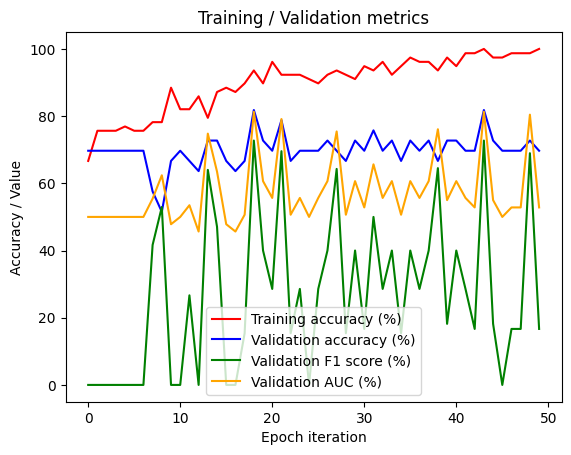

In [64]:
# Plotting the accuracy curves for this run
plt.plot(train_accuracy_list, color='red', label='Training accuracy (%)')
plt.plot(val_accuracy_list, color='blue', label='Validation accuracy (%)')
plt.plot(val_f1_tracker, color='green', label='Validation F1 score (%)')
plt.plot(val_roc_auc_tracker, color='orange', label='Validation AUC (%)')

# Adding legend, x-label, and y-label
plt.legend()
plt.xlabel('Epoch iteration')
plt.ylabel('Accuracy / Value')
plt.title('Training / Validation metrics')

# Displaying the plot
plt.show()

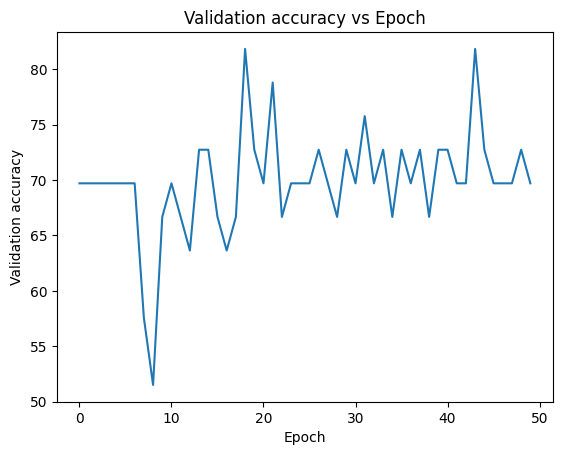

In [65]:
# Plot validation accuracy in each epoch

plt.plot(val_accuracy_list)
plt.title('Validation accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.show()

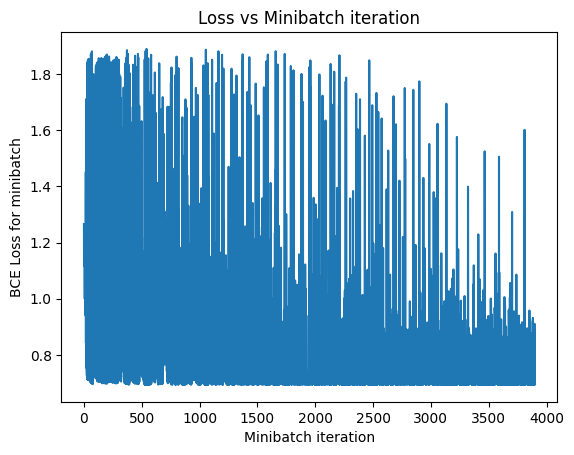

In [66]:
# Plot the loss against minibatch iteration
loss_all=[]

for i in range(len(loss_tracker)):
    loss_all.append(loss_tracker[i].item())

plt.plot(loss_all)
plt.title('Loss vs Minibatch iteration')
plt.xlabel('Minibatch iteration')
plt.ylabel('BCE Loss for minibatch')
plt.show()


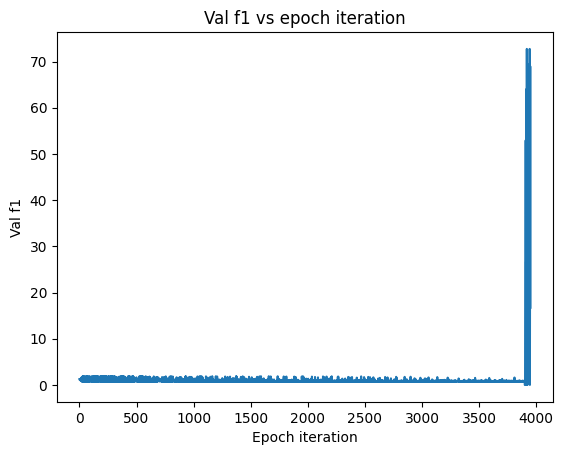

In [67]:
# Plot the val_f1 against epoch iteration
val_f1_all=[]

for i in range(len(val_f1_tracker)):
    loss_all.append(val_f1_tracker[i].item())

plt.plot(loss_all)
plt.title('Val f1 vs epoch iteration')
plt.xlabel('Epoch iteration')
plt.ylabel('Val f1')
plt.show()

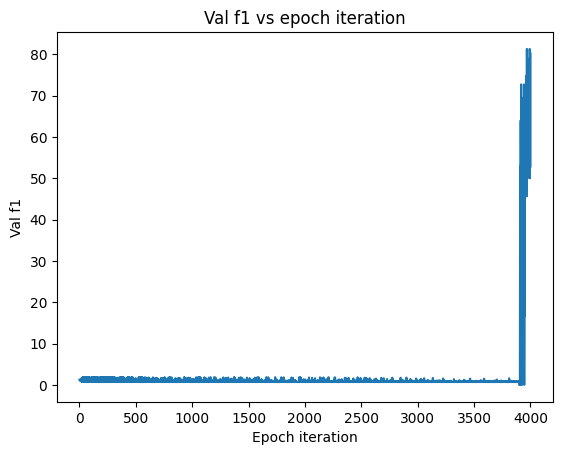

In [68]:


# Plot the val_f1 against epoch iteration
val_f1_all=[]

for i in range(len(val_roc_auc_tracker)):
    loss_all.append(val_roc_auc_tracker[i].item())

plt.plot(loss_all)
plt.title('Val f1 vs epoch iteration')
plt.xlabel('Epoch iteration')
plt.ylabel('Val f1')
plt.show()